In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

In [6]:
base_path = Path('v2/')

X_train = np.load('train_images.npy').astype(np.float32)
Y_train = np.load('train_labels.npy')

X_test = np.load('test_public_images.npy').astype(np.float32)
Y_test = np.load('test_public_labels.npy')

classes, counts = np.unique(Y_train, return_counts=True)
counts_test = np.unique(Y_test, return_counts=True)[1]

ValueError: cannot reshape array of size 15204288 into shape (10000,10,3,32,32)

In [7]:
classes_names = [
    "Avoine d'hiver",
    "Avoine de printemps",
    "Blé tendre d'hiver",
    "Blé tendre de printemps",
    "Colza d'hiver",
    "Luzerne déshydratée",
    "Luzerne",
    "Mélange de légumineuses et graminées",
    "Maïs",
    "Maïs ensilage",
    "Orge d'hiver",
    "Orge de printemps",
    "Prairie permanente - herbe",
    "Prairie permanente - ressources fourragères ligneuses",
    "Prairie en rotation longue",
    "Pomme de terre de consommation",
    "Prairie temporaire",
    "Soja",
    "Tournesol",
    "Triticale d'hiver"
]
months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

print(f'Each {X_train.shape[0]} training and {X_test.shape[0]} test samples have :\n'
      f'\t{X_train.shape[1]} images (one per month from Feb to Nov)\n'
      f'\t{X_train.shape[2]} channels (B08 Near Infrared, B04 Red, B03 Green)\n'
      f'\t{X_train.shape[3]} x {X_train.shape[4]} pixels')
print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}')

classes_df = pd.DataFrame({
    'Class Name': classes_names,
    'N Samples in Train': counts,
    'N Samples in Test': counts_test,
    'Frequency in Train': counts / counts.sum(),
    'Frequency in Test': counts_test / counts_test.sum()
},index=classes)

classes_df

NameError: name 'X_train' is not defined

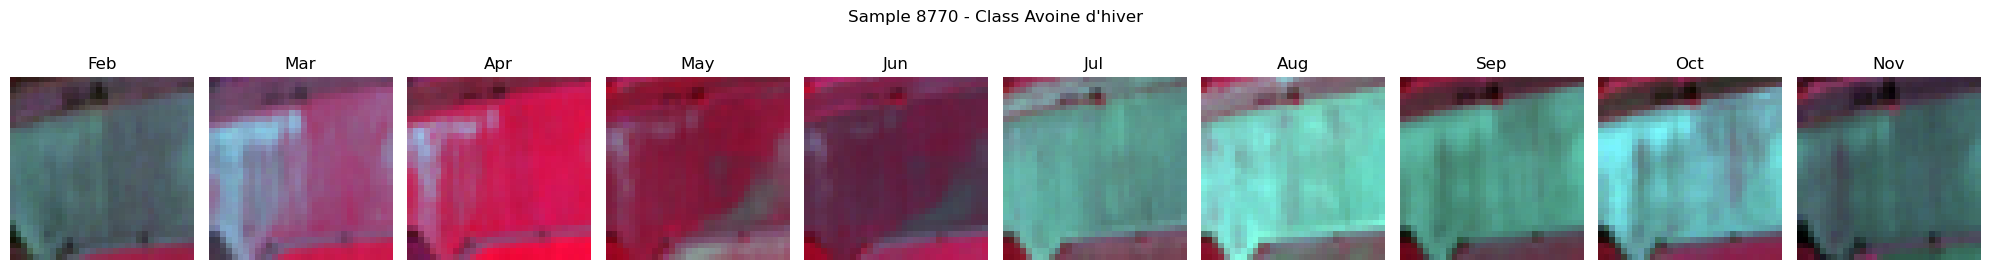

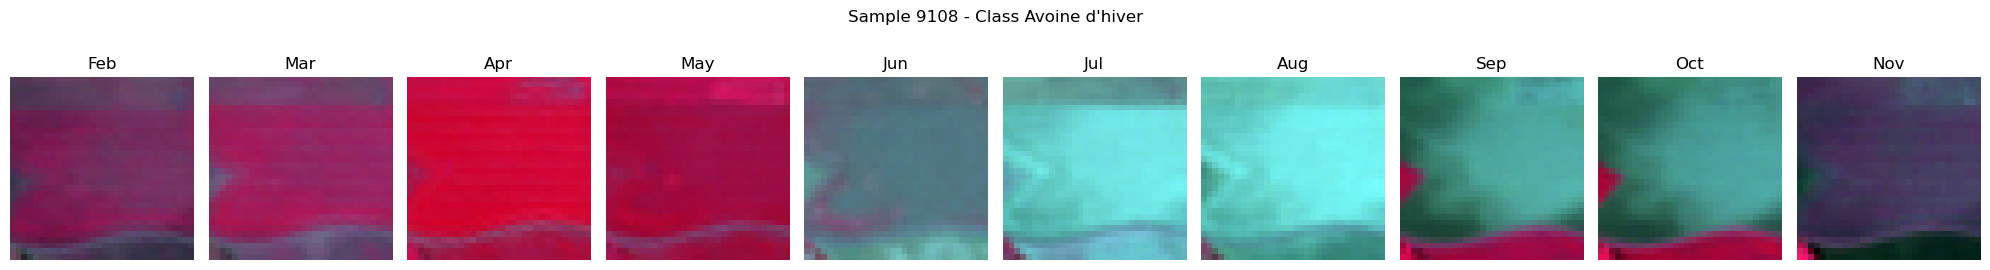

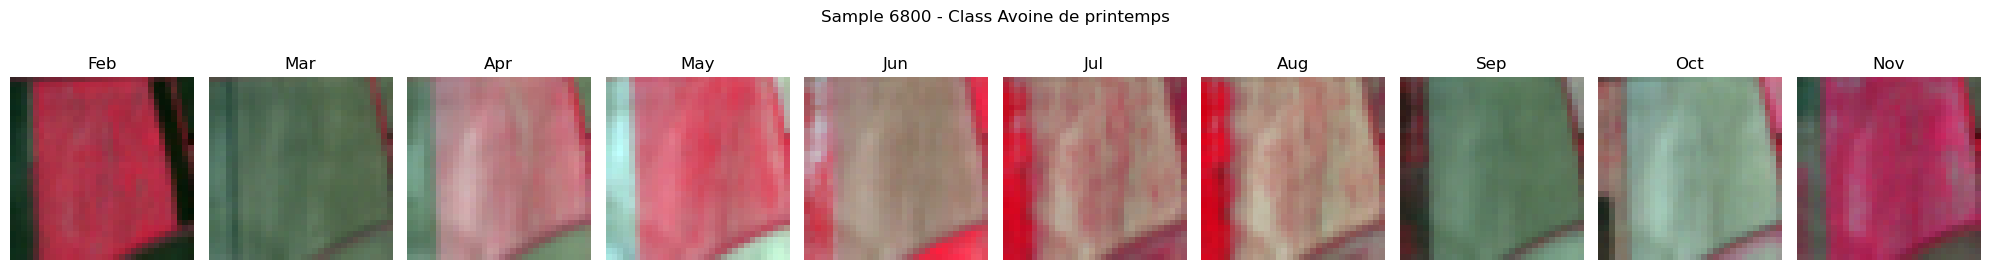

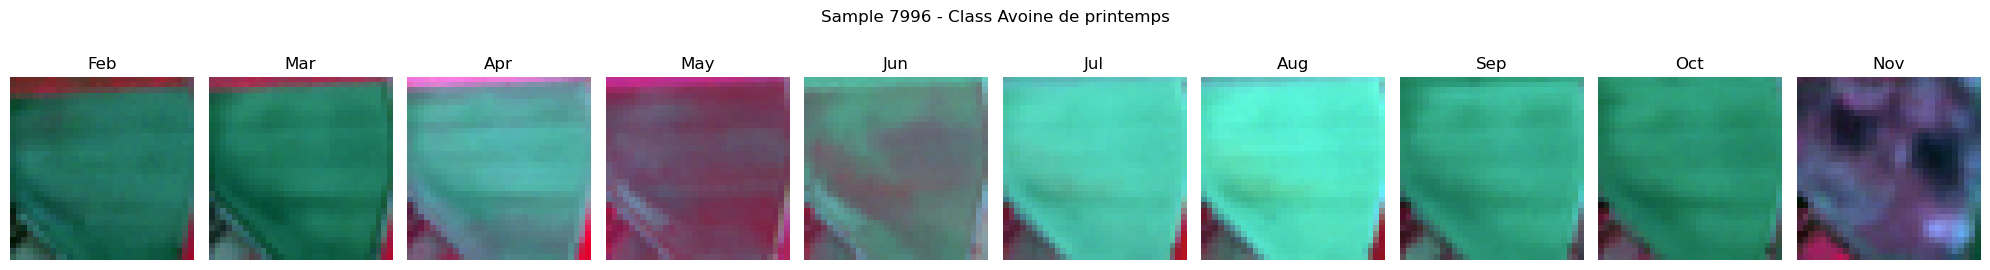

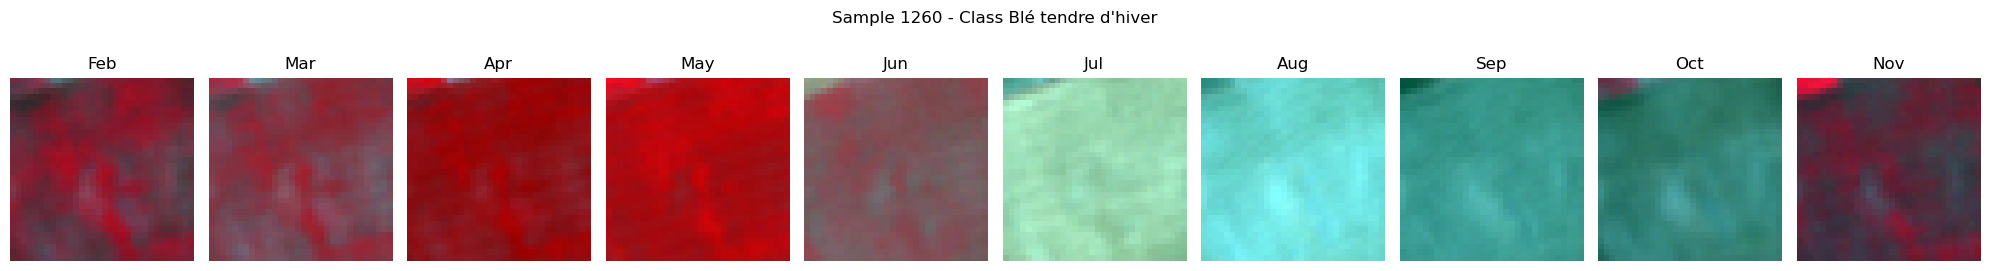

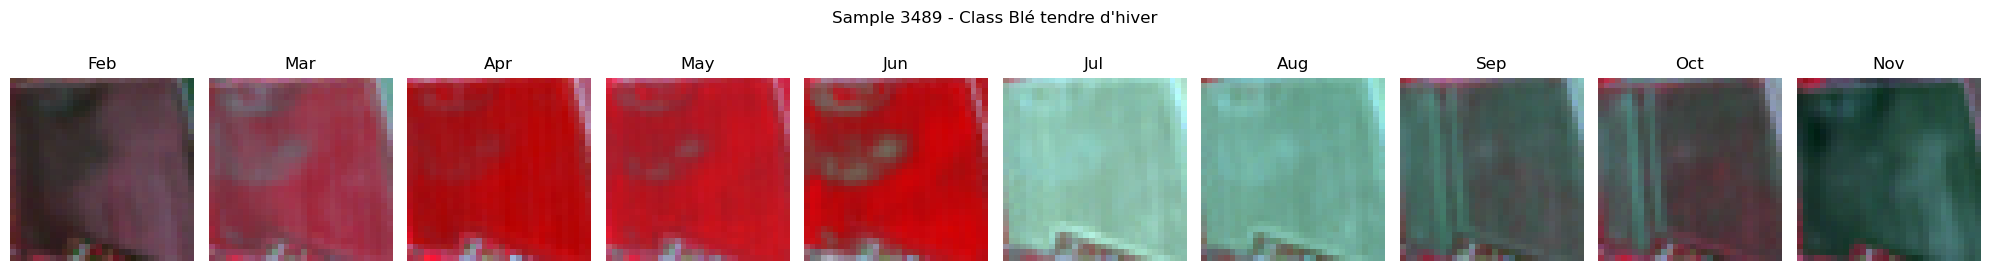

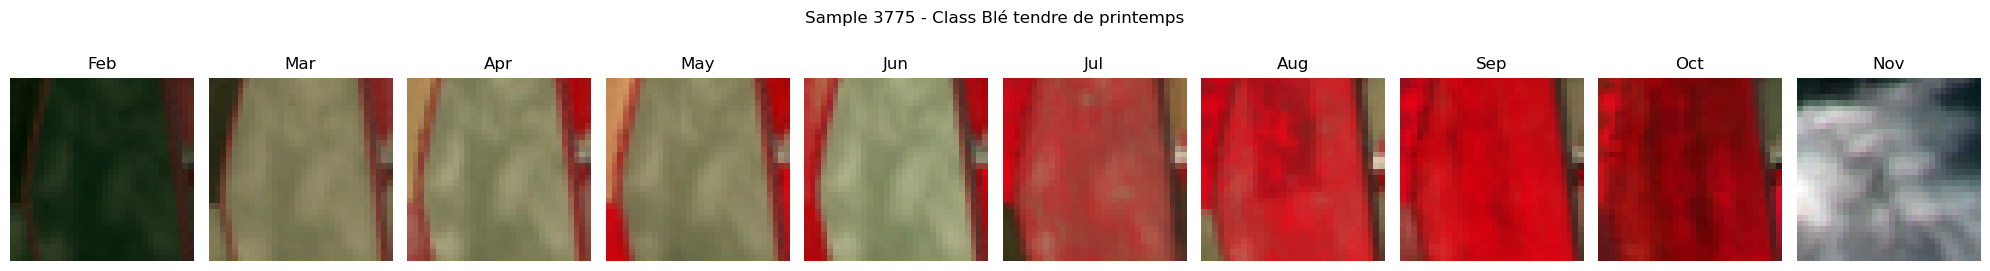

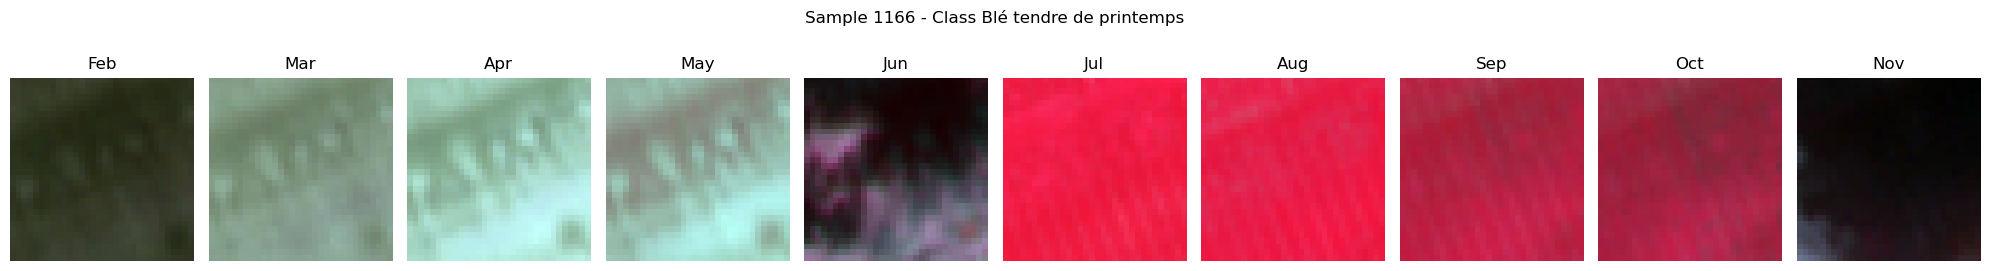

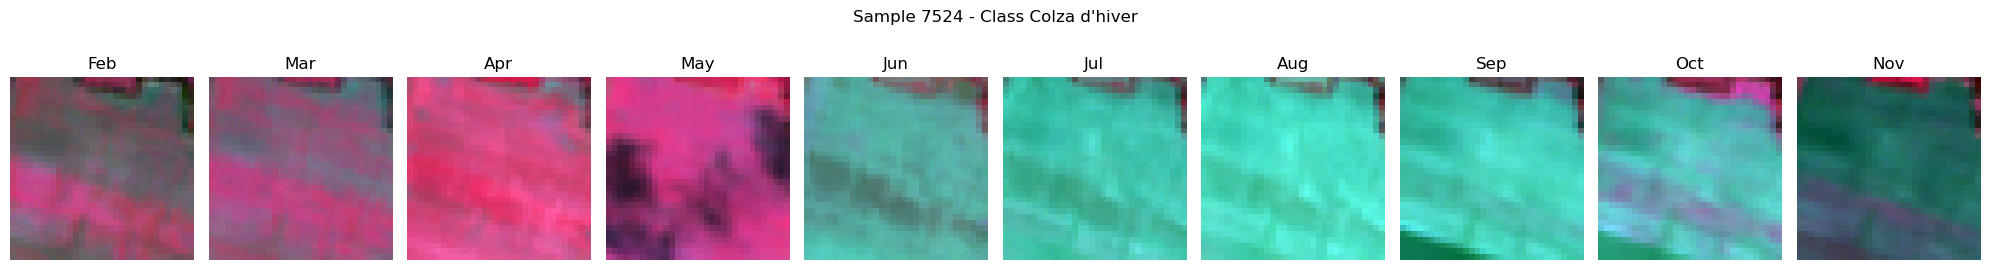

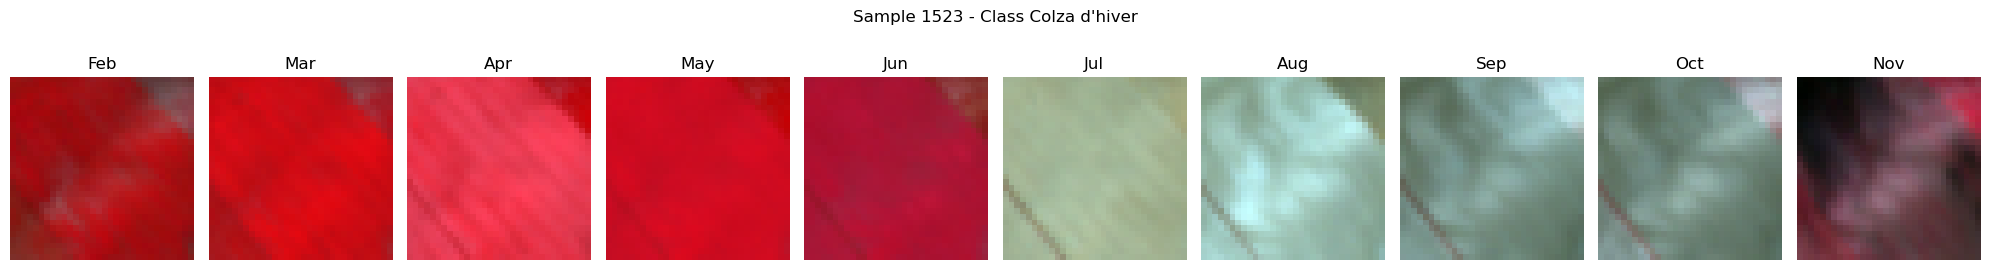

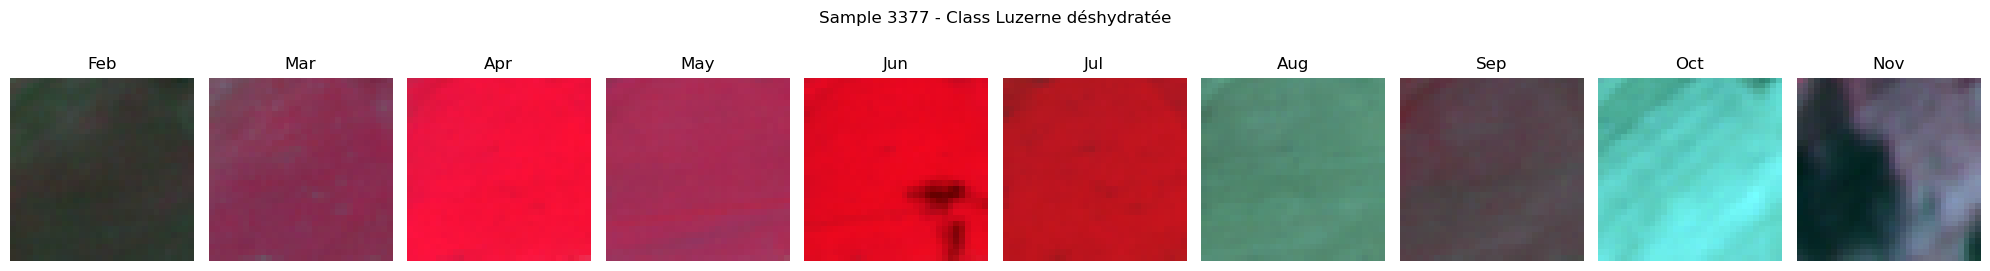

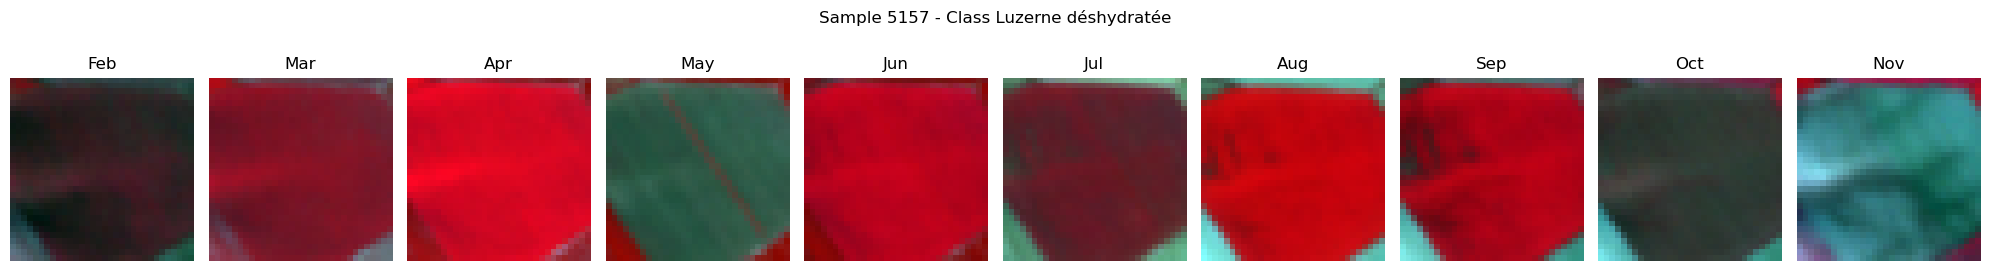

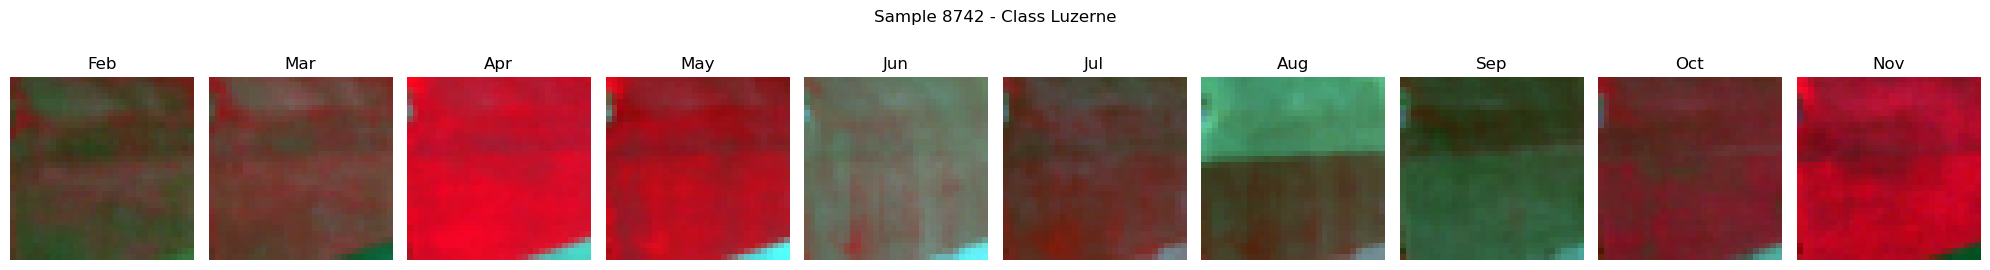

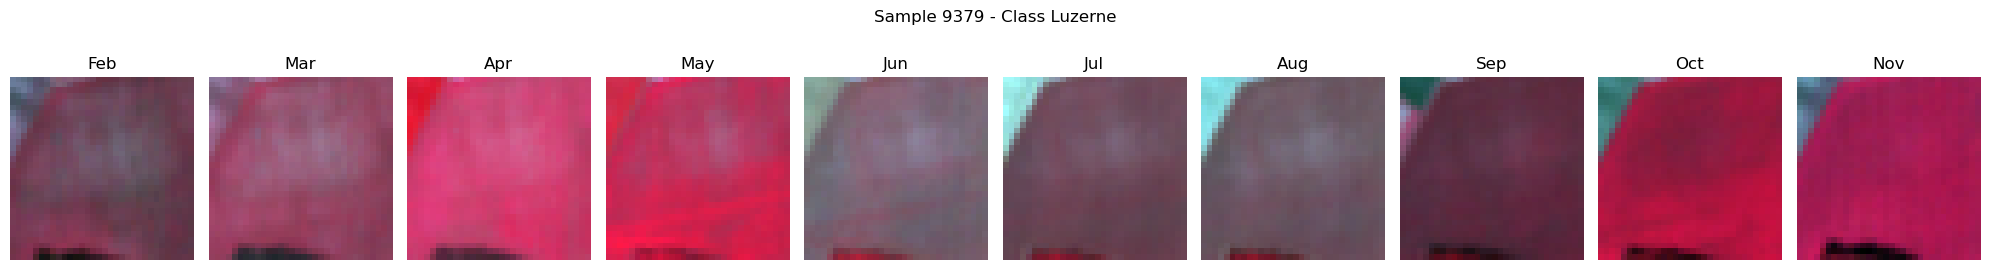

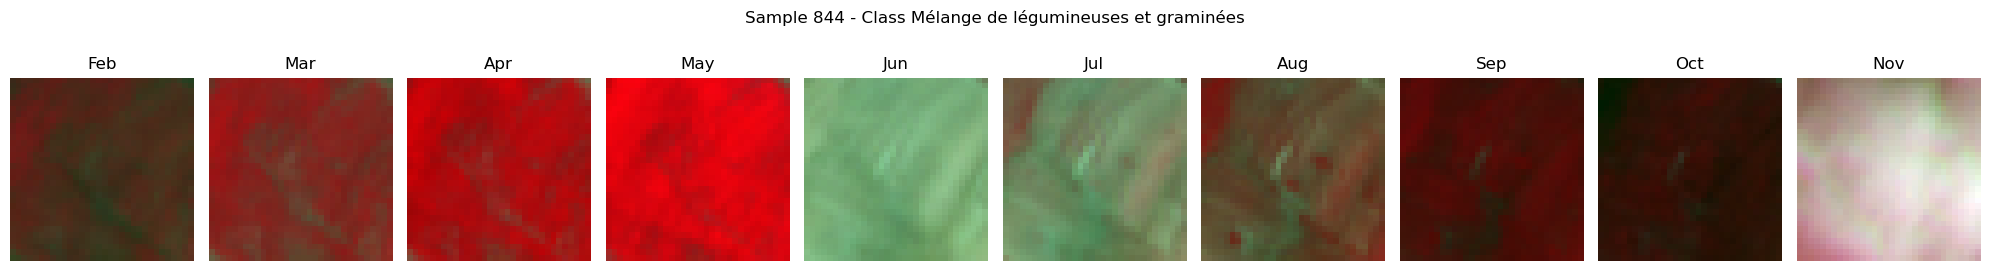

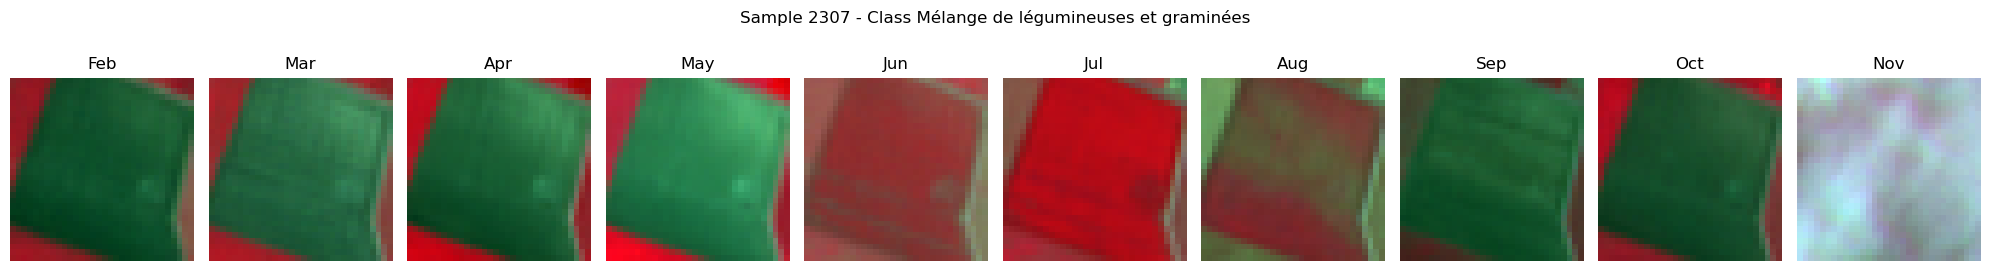

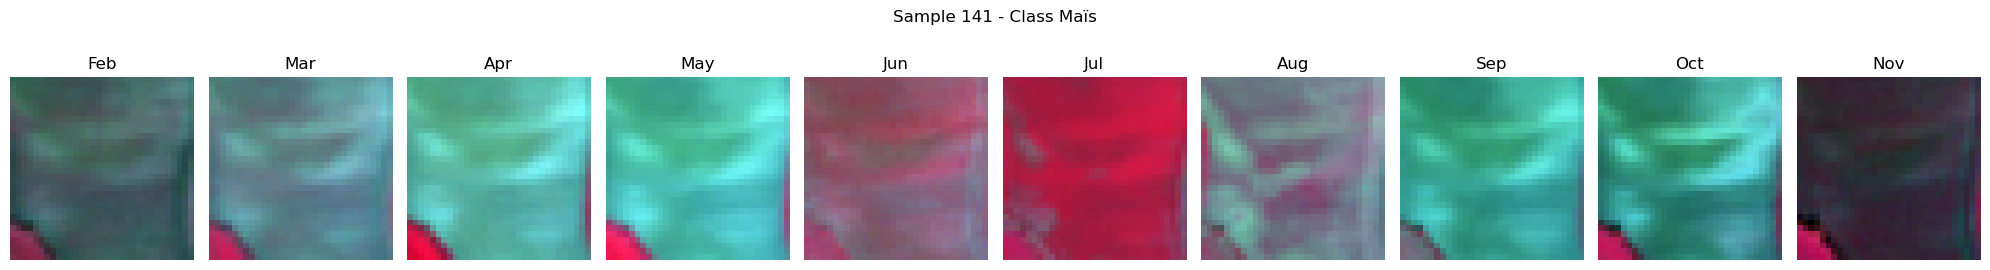

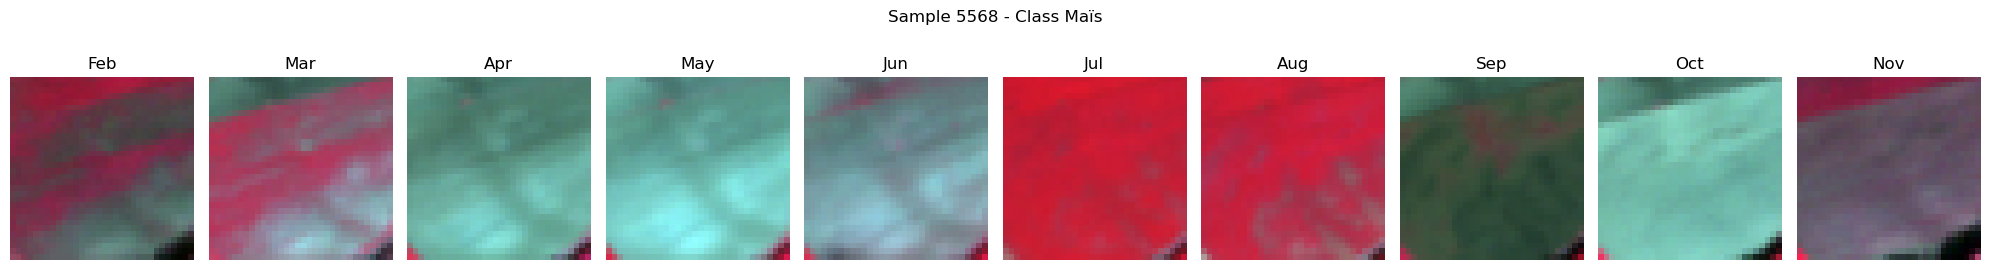

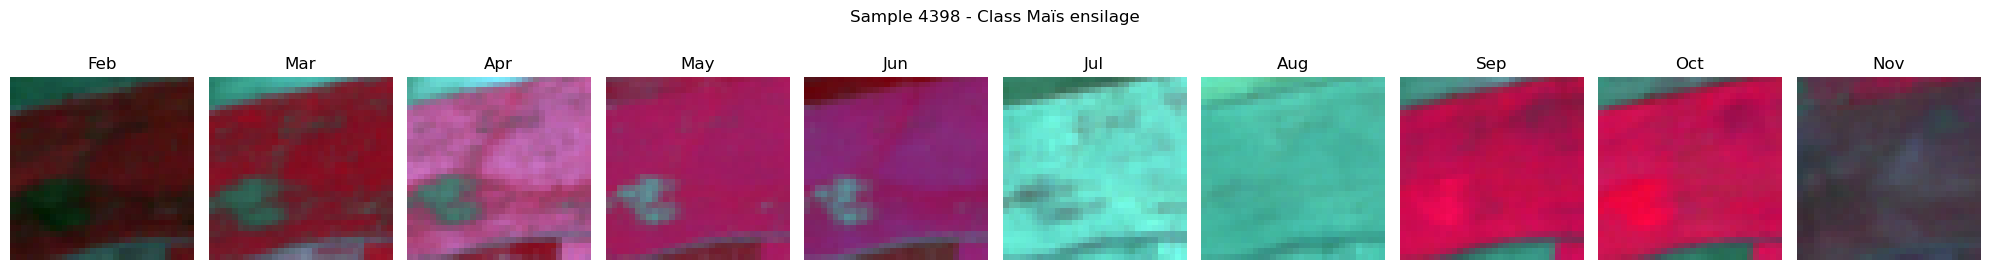

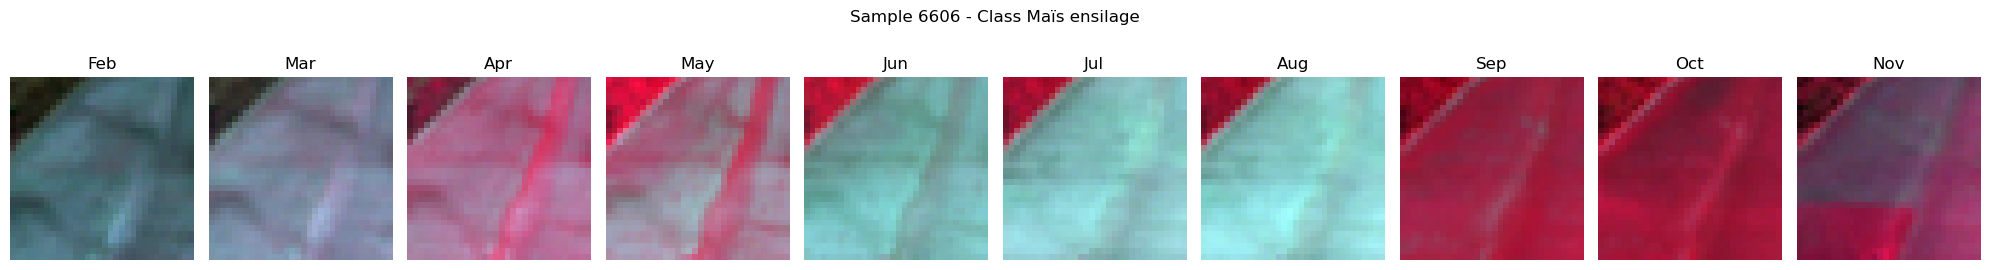

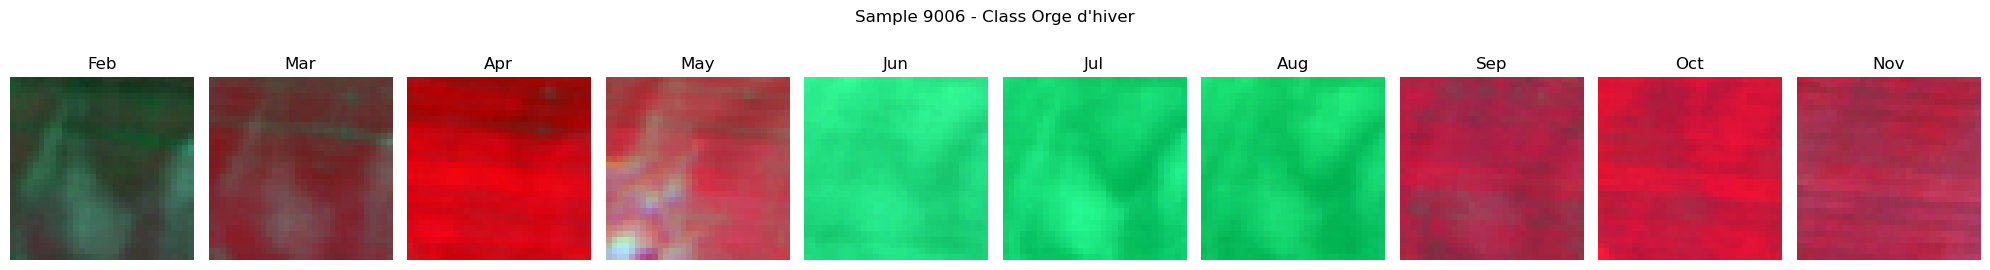

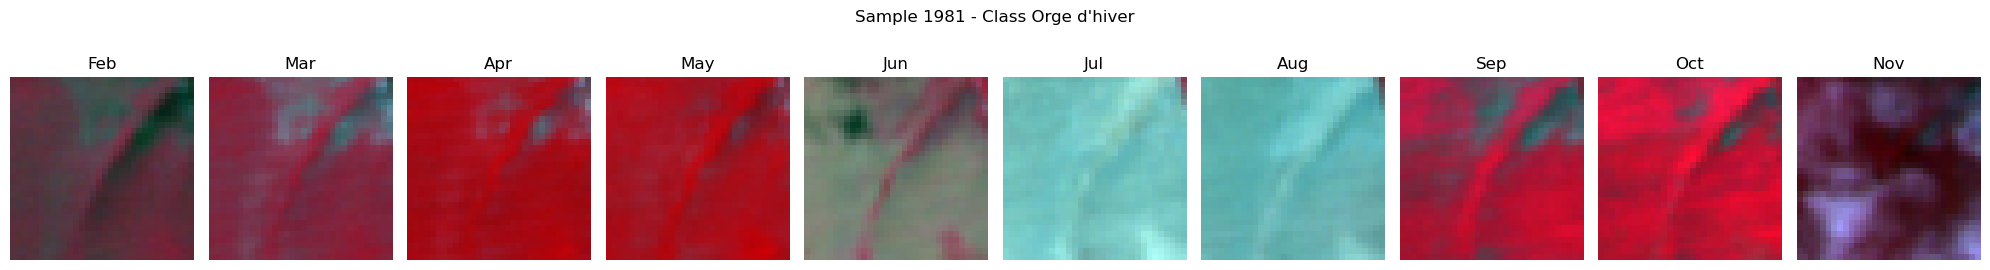

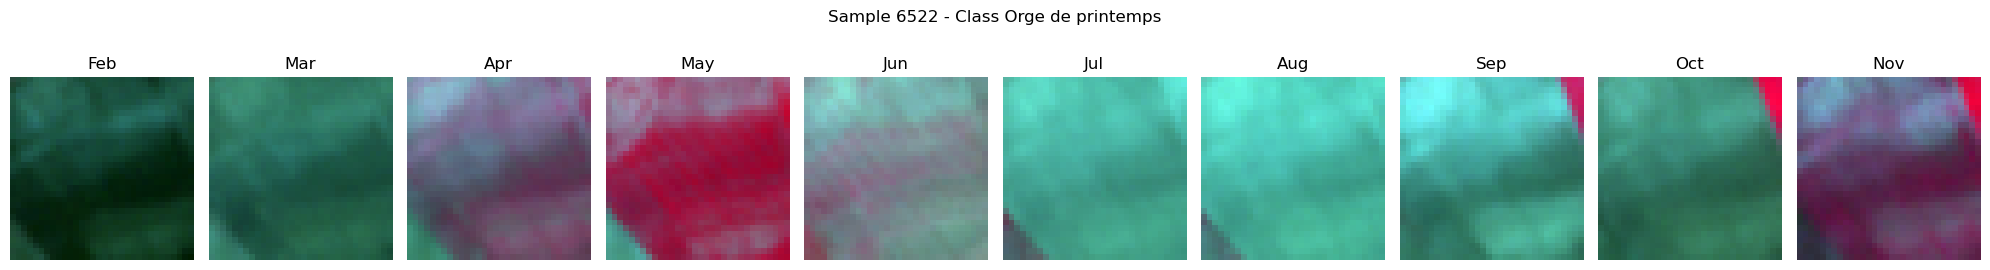

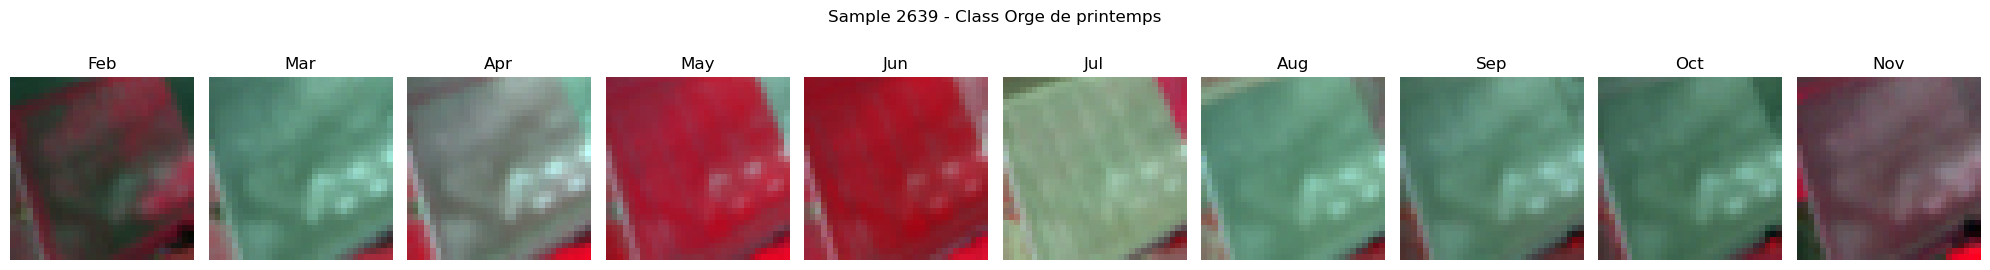

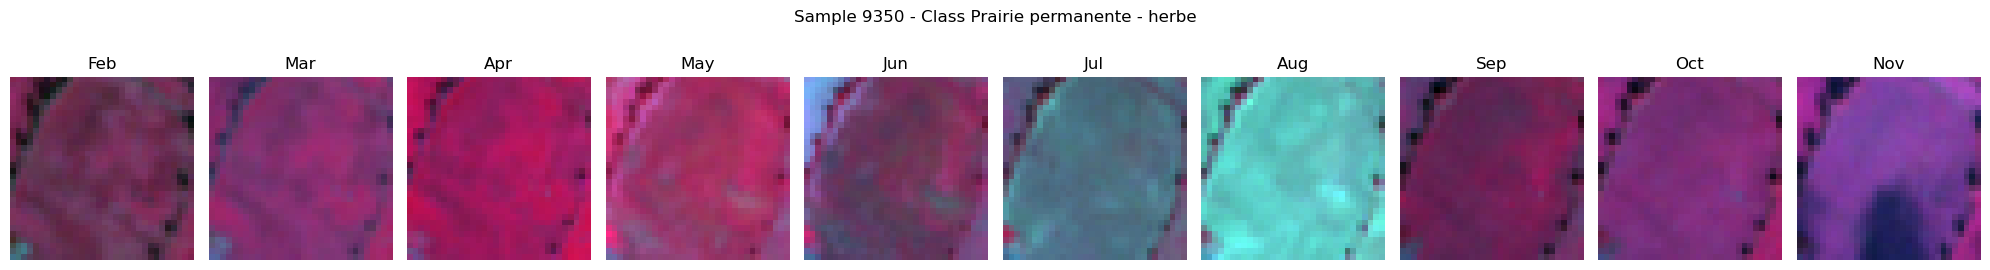

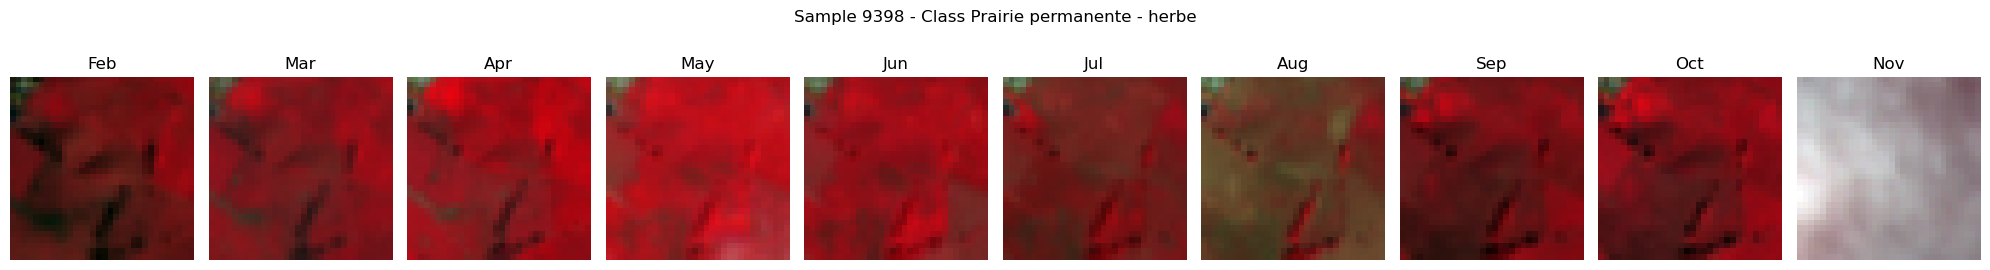

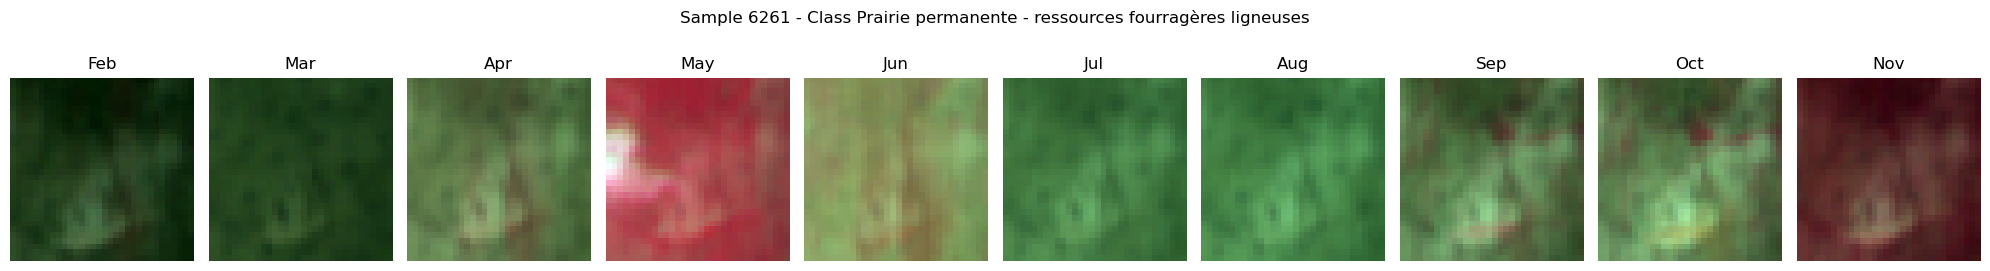

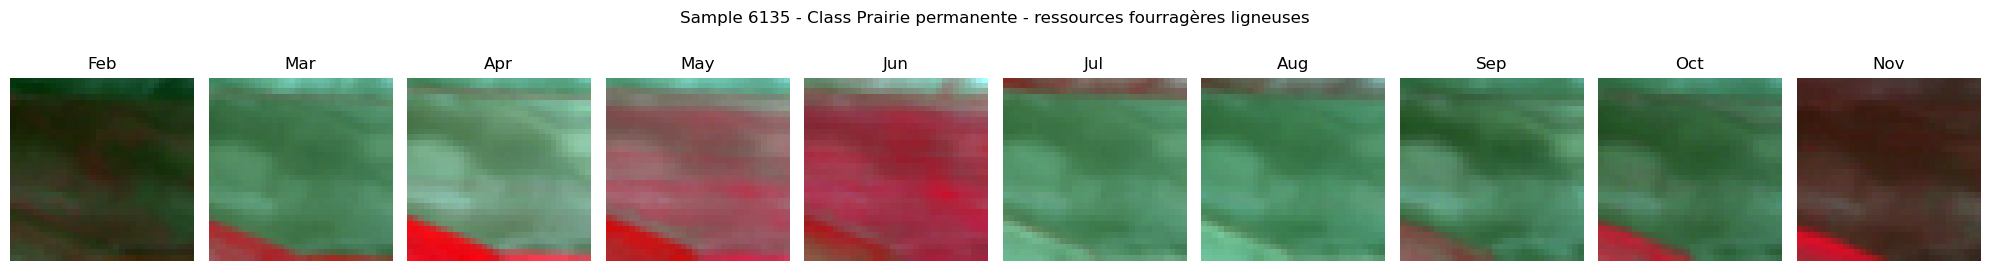

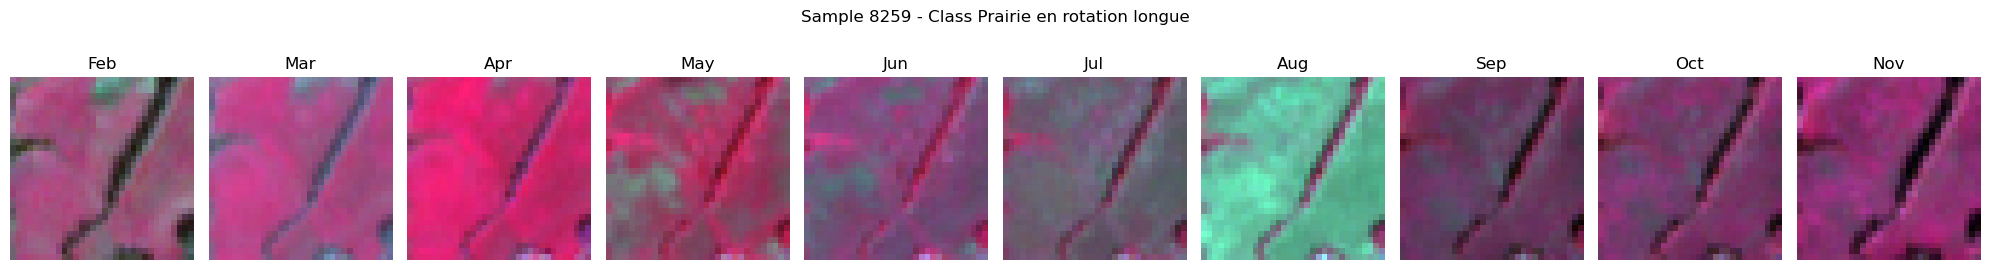

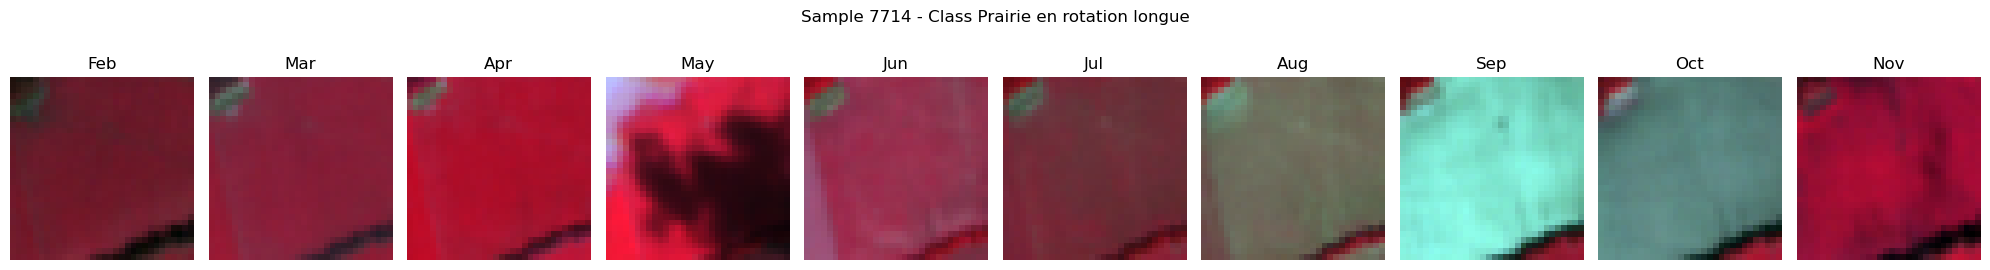

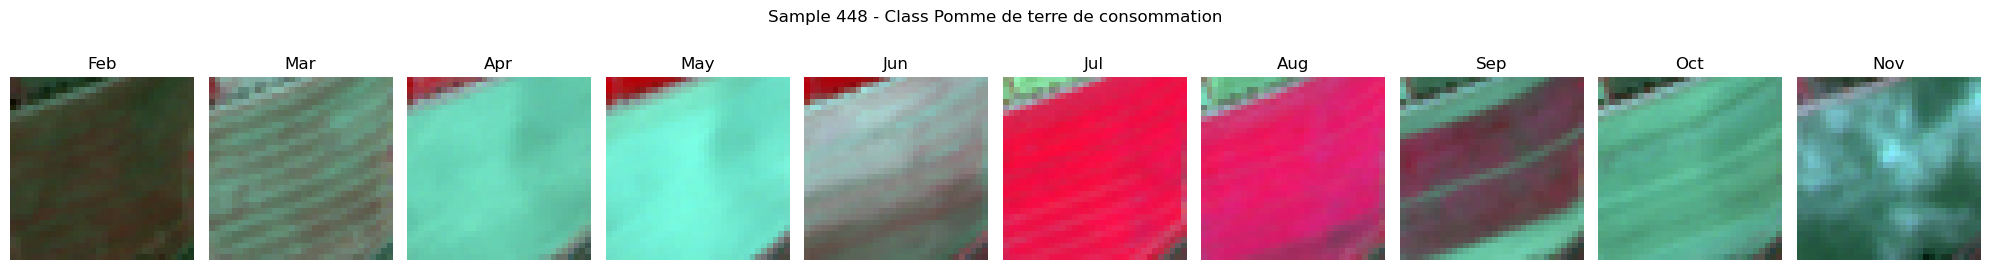

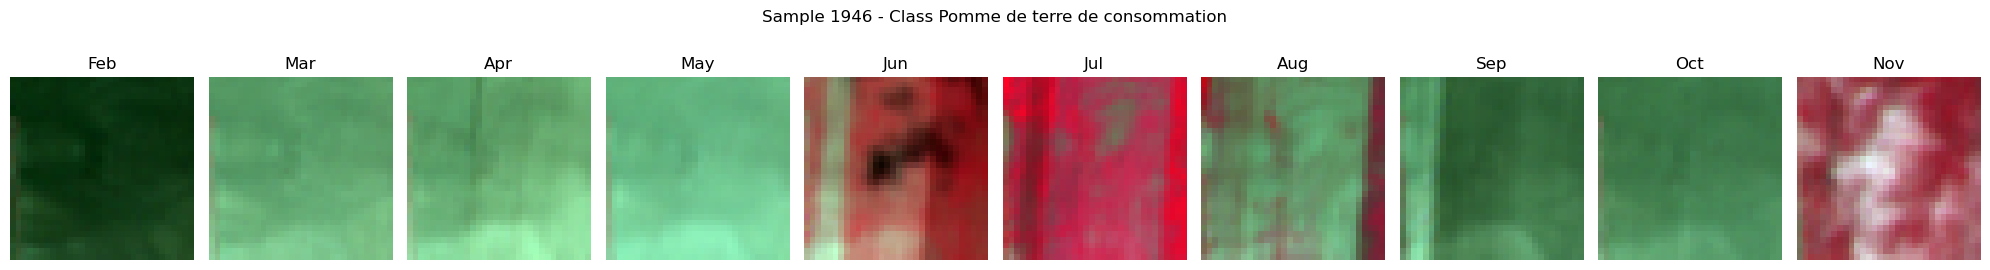

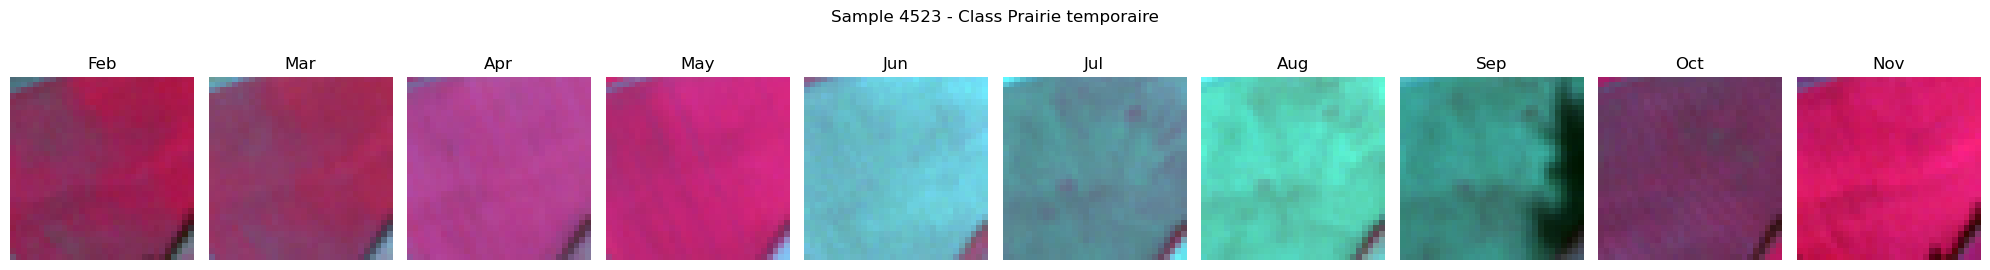

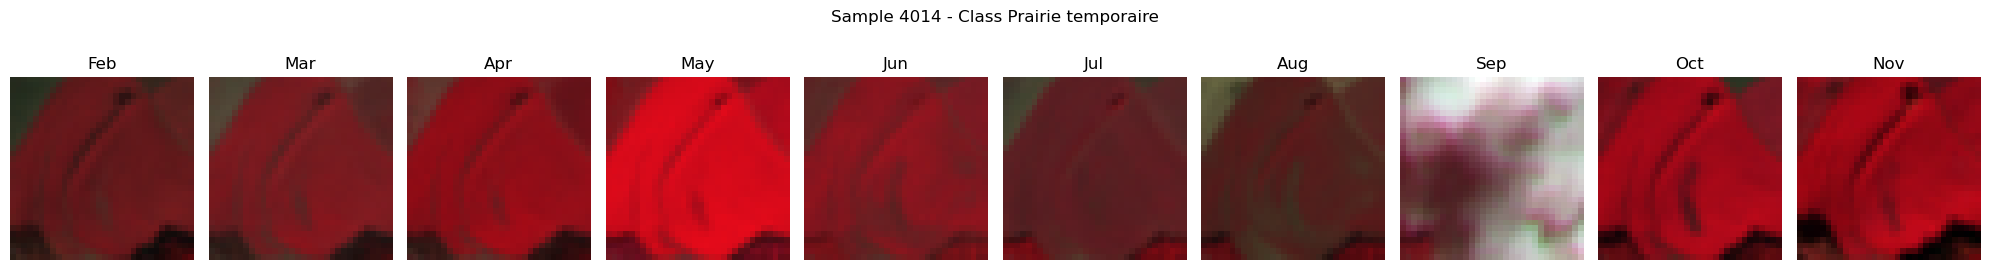

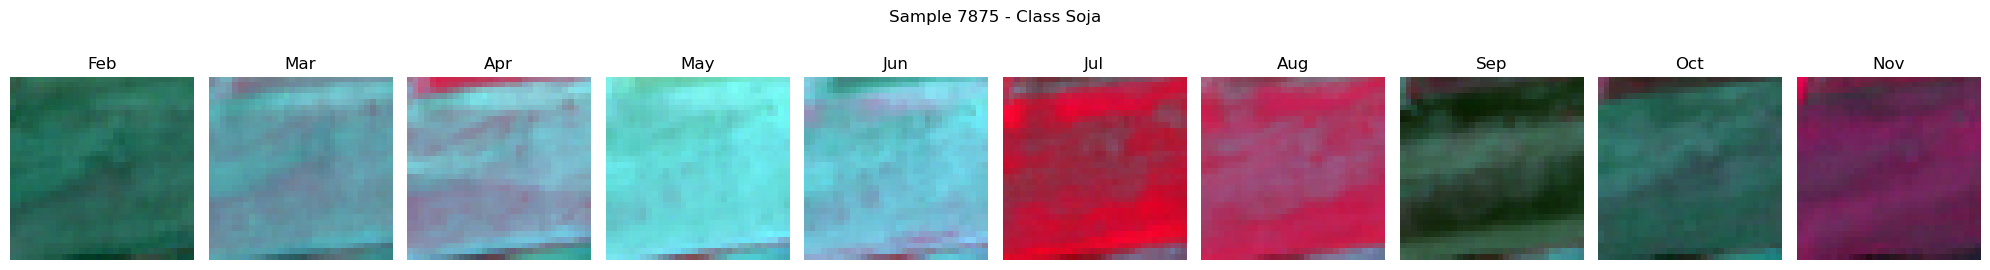

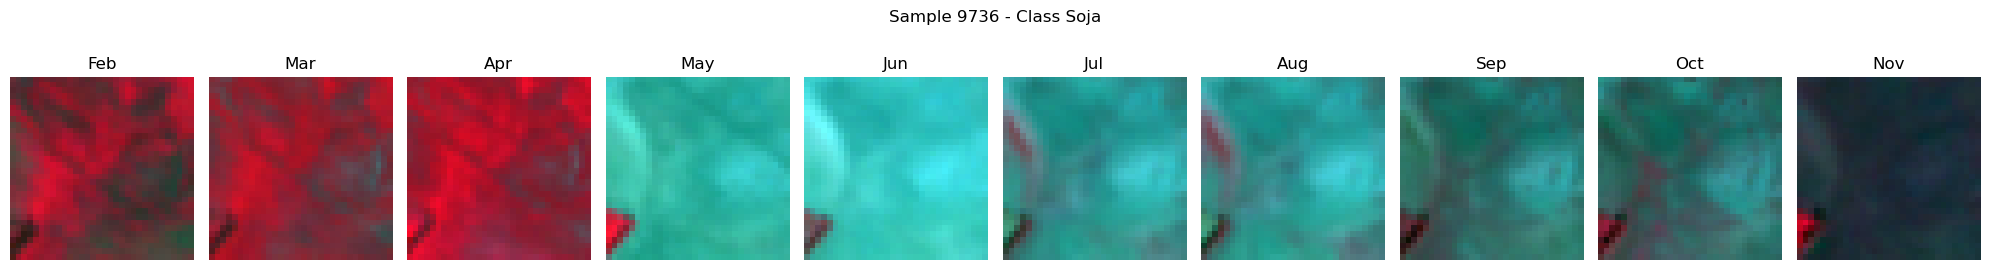

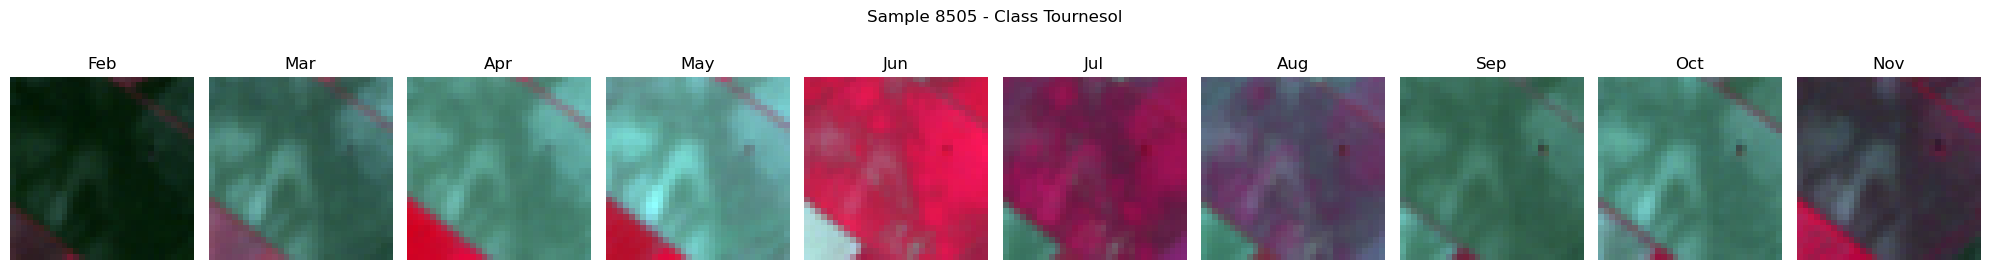

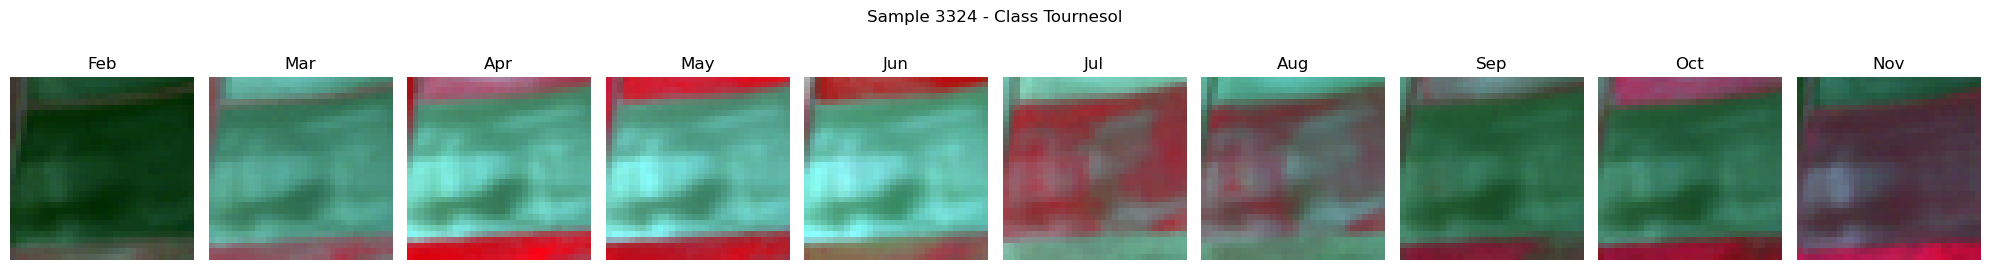

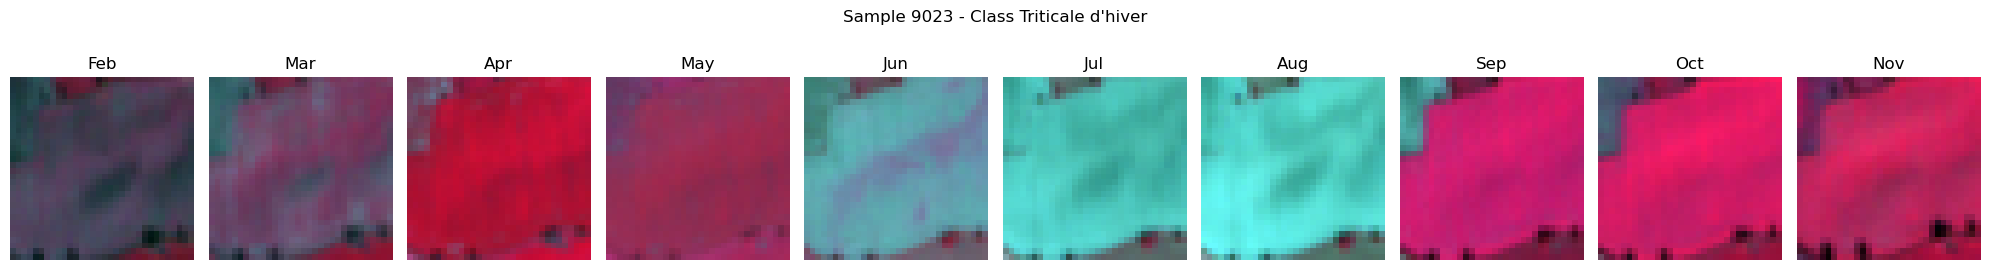

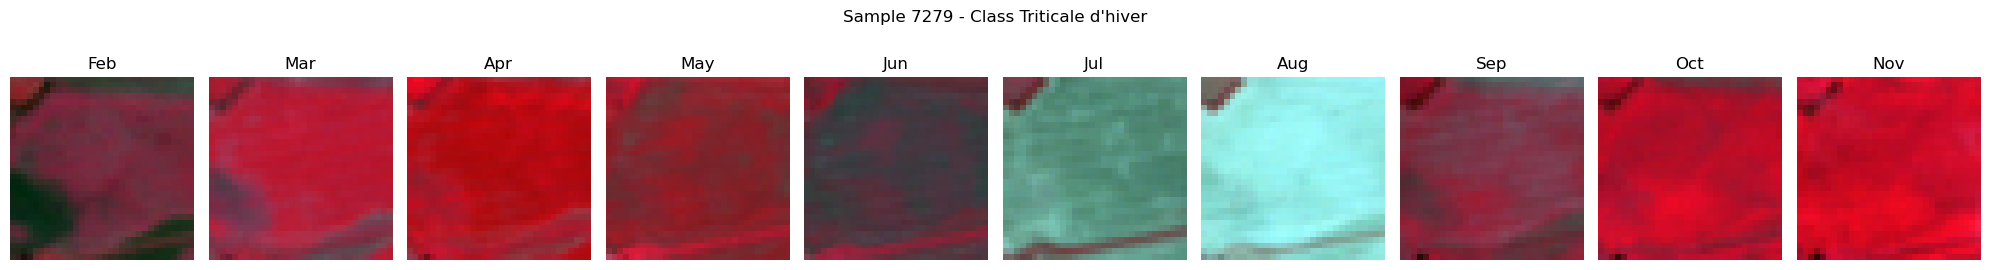

In [ ]:
def display_sample(X, Y, sample, grid_shape=(1, 10), size=2):
    x = X[sample].copy()
    y = Y[sample].copy()

    n_rows, n_cols = grid_shape
    n_images = x.shape[0]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size*n_cols, size*n_rows + 1))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    img = x.transpose(0, 2, 3, 1)
    # Normalize each channel independently
    for channel in range(img.shape[-1]):
        img_ch = img[..., channel]
        img_min = img_ch.min()
        img_max = img_ch.max()
        img[..., channel] = (img_ch - img_min) / (img_max - img_min)
    img = img.clip(0, 1)

    for i in range(n_images):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].imshow(img[i])
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{months[i]}')

    # Hide empty subplots if any
    for i in range(n_images, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')

    fig.suptitle(f'Sample {sample} - Class {classes_names[y]}')
    plt.tight_layout()
    plt.show()

def get_random_sample_of_class(X, Y, class_idx):
    """Get a random sample from a specific class"""
    class_indices = np.where(Y == class_idx)[0]
    random_idx = np.random.choice(class_indices)
    return random_idx

for i in [get_random_sample_of_class(X_train, Y_train, i//2) for i in range(len(classes)*2)]:
    display_sample(X_train, Y_train, i)

In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter

def create_simplified_dataset(X_data):

    simplified_data = []
    for sample_idx in range(X_data.shape[0]):
        for month_idx in range(X_data.shape[1]):
            image = X_data[sample_idx, month_idx, :, :, :]
            filtered_image = gaussian_filter(image, sigma=1)
            avg_rgb = np.mean(filtered_image, axis=(1, 2))
            simplified_data.append({
              'sample_id':sample_idx,
              'month':month_idx,
              'R': avg_rgb[0],
              'G': avg_rgb[1],
              'B': avg_rgb[2]
            })

    return pd.DataFrame(simplified_data)


simplified_train_df = create_simplified_dataset(X_train)
print(simplified_train_df.head())

simplified_test_df = create_simplified_dataset(X_test)
print(simplified_test_df.head())

NameError: name 'X_train' is not defined

In [ ]:
import tensorflow as tf


model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(30,)),
  tf.keras.layers.Dense(25, activation='relu'),
  tf.keras.layers.Dense(25, activation='relu'),
  tf.keras.layers.Dense(20, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

In [ ]:
X_train_nn = simplified_train_df.drop(columns=['sample_id', 'month']).values.reshape(-1, 10, 3)
X_test_nn = simplified_test_df.drop(columns=['sample_id', 'month']).values.reshape(-1, 10, 3)


model.fit(X_train_nn, Y_train, epochs=10)

loss, accuracy = model.evaluate(X_test_nn, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Y_pred = np.argmax(model.predict(X_test_nn), axis=1)
print(classification_report(Y_test, Y_pred))